# Independent component analysis per eliminar soroll visual dels videos

En aquest document explicarem com eliminar un soroll concret, linies horitzontals markades, d'un video de neurones, pas a pas.
També hi ha un programa amb una API per a usar sense haver de anar pas a pas i més cómoda, explicada a [api.qmd](aquest fitxer).

## Imports

Comencem important tot els paquets que ens seran necessaris al llarg del procés:

In [1]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.ndimage import gaussian_filter  # type: ignore
from sklearn.decomposition import PCA, FastICA  # type: ignore
import skvideo.io  # type: ignore

## Carreguem el video

Carreguem el video a python, que serà una array de 3 dimensions, una temporal i dos espacials, representant el video en blanc i negre.

In [4]:
video_path = "/Users/annateruel/Desktop/2.avi"
cap = cv2.VideoCapture(video_path)
frames = []
frame_shape = None

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame_gray)

    if frame_shape is None:
        frame_shape = frame_gray.shape

    frame_count += 1

fps = int(cap.get(cv2.CAP_PROP_FPS))
cap.release()

frames = np.array(frames)

[Original video](0.avi)


## Apliquem un filtre gaussia espacial

Abans de poder aplicar l'anàlisi de components independents (ICA), processem el
video amb un filtre gaussia espacial, com expliquen a
[Analyzing Calcium Imaging Data Using Python](https://focalplane.biologists.com/2023/10/27/analyzing-calcium-imaging-data-using-python/)
"Cumulative explained variance plot shows how much of data variance is contained in the first N principal components.
If the neural activity of all cells is highly correlated, then first principal component will explain most of the data.
Data with more noise, or more heterogenous activity, will have slower accumulation of explained variance.
We can see that by comparing PCA of original data and PCA of data blurred using spatial Gaussian filter."

En el següent article també expliquen com es relaciona el tamany del kernel del filtre gaussia
amb la relació senyal soroll [Comparing Analysis Methods in Functional Calcium Imaging of the Insect Brain](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4457531/)

Nosaltres només utilitzarem la variable sigma, que determina la "força" del kernel, ja que aquesta determina unicament el tamany del kernel.
Utilitzarem la mínima força que ens proporcione una quantitat de variança d'uns 0.95 en les primeres 100 a 120 components o així.

In [5]:
def cumulative_variance_from_gauss_sigma(sigma, frames):
    # We apply the filter spatially to each frame, leaving the time axis (0 axis)
    if sigma > 0:
        frames = gaussian_filter(frames, sigma = sigma, axes=(1,2))
    # Convertim la array de 3 a 2 dimensions
    frames = frames.reshape(len(frames), -1)
    pca = PCA(random_state=0)
    pca.fit(frames)
    return np.cumsum(pca.explained_variance_ratio_)

::: {.callout-note}
El següent codi pot tardar uns minuts, ja que fer el PCA pot costar uns minuts cada vegada.
:::

TypeError: gaussian_filter() got an unexpected keyword argument 'axes'

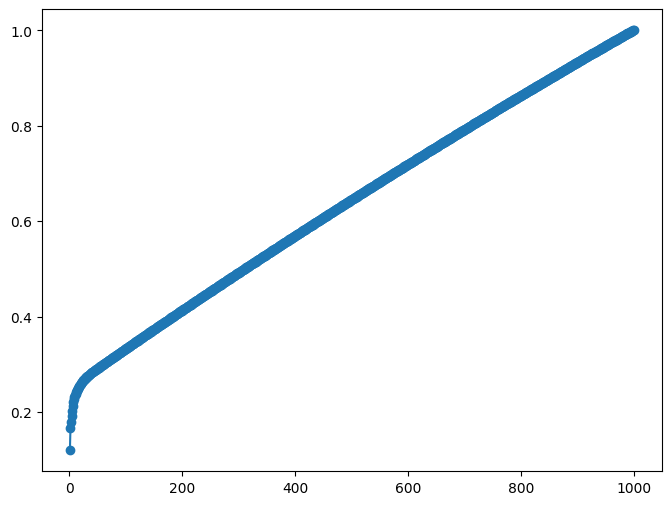

In [8]:
plt.figure(figsize=(8, 6))
cumulative_variance_0 = cumulative_variance_from_gauss_sigma(0, frames)
plt.plot(
    np.arange(1, len(cumulative_variance_0) + 1),
    cumulative_variance_0,
    label='NoGauss',
    marker="o",
    linestyle="-",
)
cumulative_variance_1 = cumulative_variance_from_gauss_sigma(1, frames)
plt.plot(
    np.arange(1, len(cumulative_variance_1) + 1),
    cumulative_variance_1,
    label='Sigma1',
    marker="o",
    linestyle="-",
)
cumulative_variance_2 = cumulative_variance_from_gauss_sigma(2, frames)
plt.plot(
    np.arange(1, len(cumulative_variance_2) + 1),
    cumulative_variance_2,
    label='Sigma2',
    marker="o",
    linestyle="-",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of PCA Components")
plt.grid()
plt.legend()
plt.show()

També podem vore com afecta a la qualitat de la imatge i dels detalls aplicar aquest filtre:

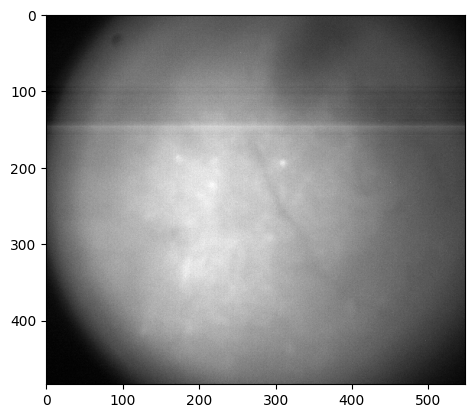

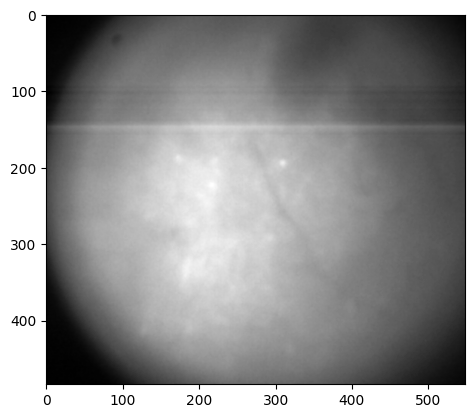

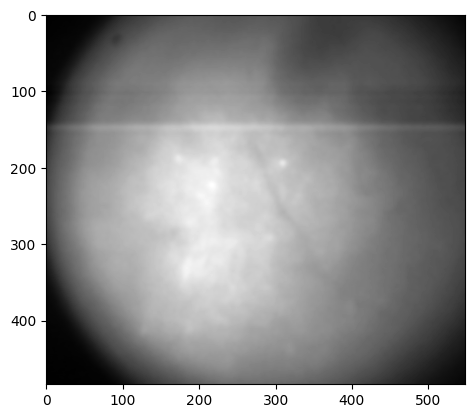

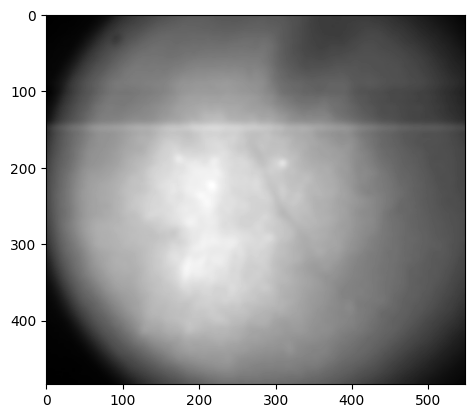

In [9]:
#| layout-ncol: 2
#| layout-nrow: 2
#| fig-cap: 
#|   - "No Gauss filtering"
#|   - "Gauss filter sigma=1"
#|   - "Gauss filter sigma=2"
#|   - "Gauss filter sigma=3"

frame_0 = frames[0]
fig, ax = plt.subplots();
ax.imshow(frame_0, cmap='gray');

frame_gauss_1 = gaussian_filter(frame_0, sigma=1)
fig, ax = plt.subplots();
ax.imshow(frame_gauss_1, cmap='gray');

frame_gauss_2 = gaussian_filter(frame_0, sigma=2)
fig, ax = plt.subplots();
ax.imshow(frame_gauss_2, cmap='gray');

frame_gauss_3 = gaussian_filter(frame_0, sigma=3)
fig, ax = plt.subplots();
ax.imshow(frame_gauss_3, cmap='gray');

Així, veiem que entre 1 i 2 seria suficient, podem agafar 1.5.

## Apliquem el independent component analysis

Com ja hem vist, apliquem un filtre gaussia al video amb sigma 1.5 i seleccionem suficients components
com per a arribar a uns 0.95 de variança explicada per les components.
Per poder aplicar el PCA al video, primer aplanem cada frame a una array de una dimensió,
deixant la matriu de frames en dos dimensions, una la temporal i l'altra la llista de pixels.


In [16]:
blur_frames = gaussian_filter(frames, sigma = 1.5, axes=(1,2))
# Convertim la array de 3 a 2 dimensions
blur_frames = blur_frames.reshape(len(blur_frames), -1)
pca = PCA(random_state=0)
pca.fit(blur_frames)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.searchsorted(cumulative_variance, 0.9) + 1
print(f"Necessitem {n_components_90} components per mantindre un 90% de variança.")
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
print(f"Necessitem {n_components_95} components per mantindre un 95% de variança.")
n_components_96 = np.searchsorted(cumulative_variance, 0.96) + 1
print(f"Necessitem {n_components_96} components per mantindre un 96% de variança.")
n_components_97 = np.searchsorted(cumulative_variance, 0.97) + 1
print(f"Necessitem {n_components_97} components per mantindre un 97% de variança.")

Necessitem 45 components per mantindre un 90% de variança.
Necessitem 88 components per mantindre un 95% de variança.
Necessitem 117 components per mantindre un 96% de variança.
Necessitem 222 components per mantindre un 97% de variança.


A aquestes components, seleccionades per quantitat de variança explicada, li apliquem el ICA
per tractar de separar les fonts que siguen més estadísticament independents de la variació, i així
aïllem el soroll de la resta, que ens eixirà en diverses components.

Elegim 117 per mantindre tota la variança possible i per raons que vindran en la següent secció, respecte
a la selecció de les components.

In [17]:
n_components = 117
pca = PCA(n_components=n_components, random_state=0)
pca_components = pca.fit_transform(blur_frames)
ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
ica_components = ica.fit_transform(pca_components)

## Seleccionem les components que ens quedem per a la reconstrucció del video

Podem automatitzar la selecció de les components per a reconstruir el video, sabent que
aquelles components que codifiquen alguna part del soroll, mostraran unes línies verticals
molt pronunciades a les seues components espacials (aquelles que donen un pes a cada pixel
del video per a la reconstrucció a partir de la component temporal).

Veiem com son les components.
Només mostrarem les primeres 9 per poder anar visalitzant el que estem fent.

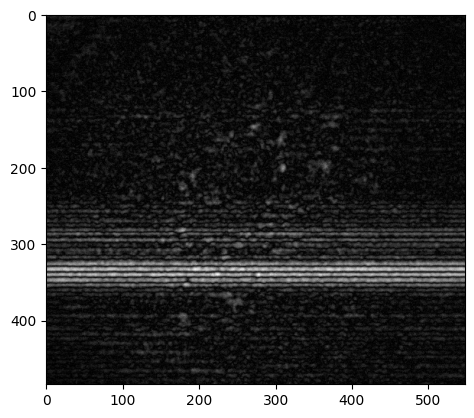

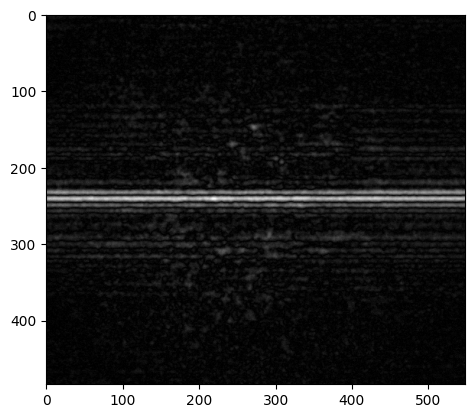

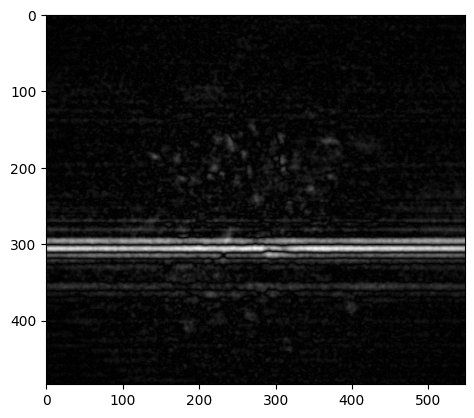

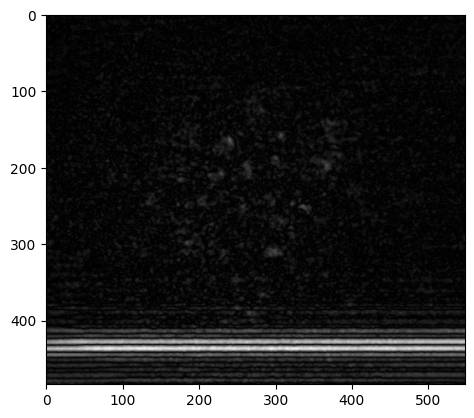

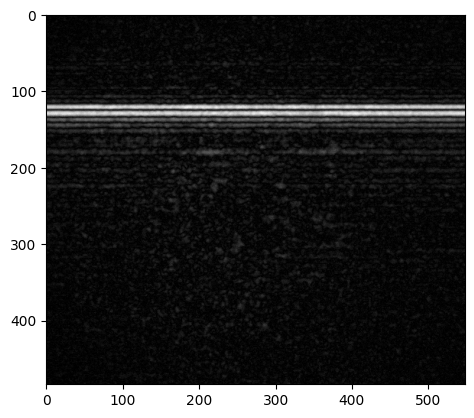

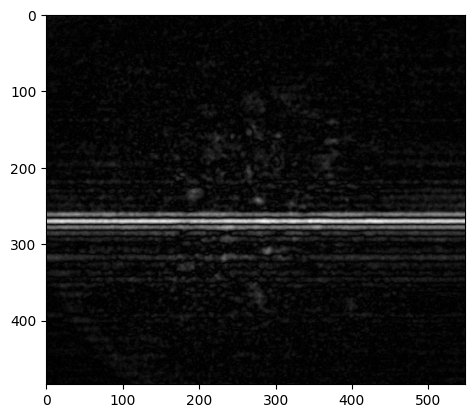

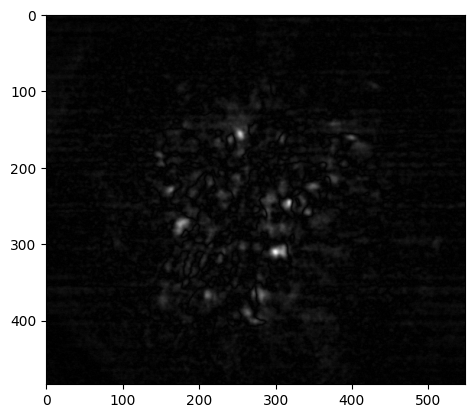

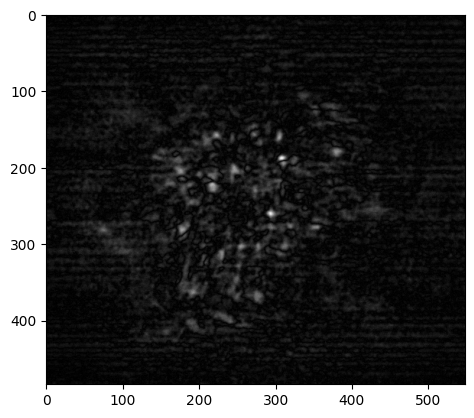

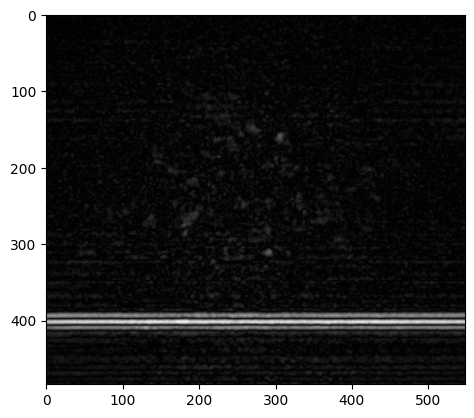

In [18]:
#| layout-ncol: 3
#| layout-nrow: 3
#| fig-cap: 
#|   - "Component 1"
#|   - "Component 2"
#|   - "Component 3"
#|   - "Component 4"
#|   - "Component 5"
#|   - "Component 6"
#|   - "Component 7"
#|   - "Component 8"
#|   - "Component 9"

pca_spatial_components = pca.components_[:n_components]
ica_spatial_components = ica.components_[:n_components]
component_maps = np.zeros((n_components, *frame_shape))
for i in range(n_components):
    # Calculate ICA component in the original frame space
    ica_component = np.matmul(pca_spatial_components.T, ica_spatial_components[i, :]).reshape(
        frame_shape
    )
    component_maps[i] = ica_component

# We are interested in absolute value strength
component_maps = abs(component_maps)
component_maps = cv2.normalize(
    component_maps, None, 0, 255, cv2.NORM_MINMAX
).astype(np.uint8)  # type: ignore

for i in range(9):
    fig, ax = plt.subplots()
    ax.imshow(component_maps[i], cmap='gray')

Podem vore com algunes components tenen una franja molt clara, aquestes son les que volem llevar.
Apliquem així el següent filtre.
Primer, converim la imatge en binaria, blanc i negre:

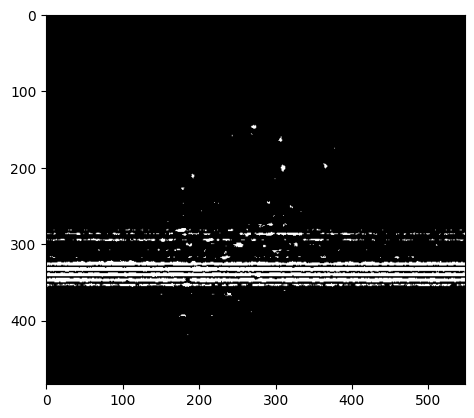

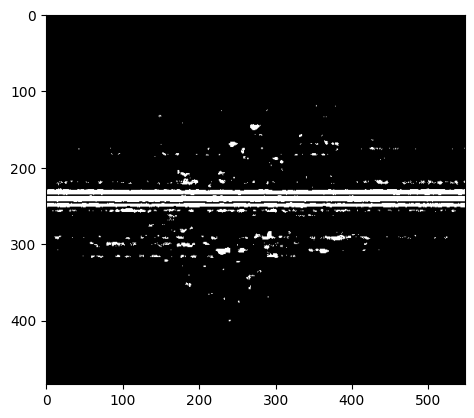

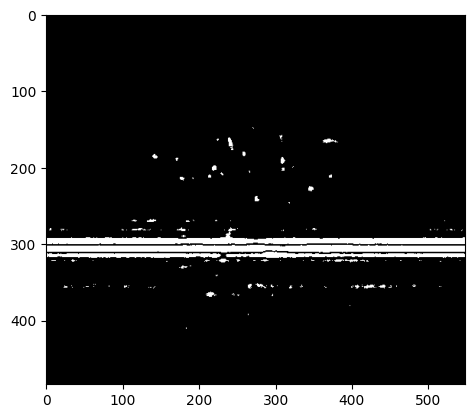

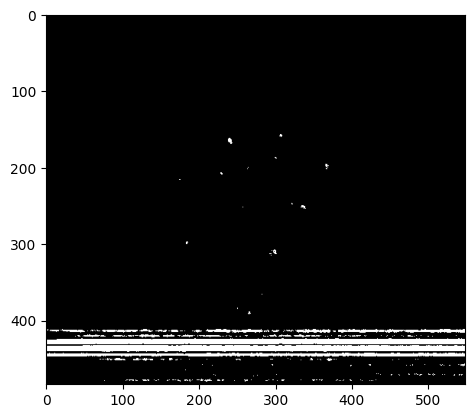

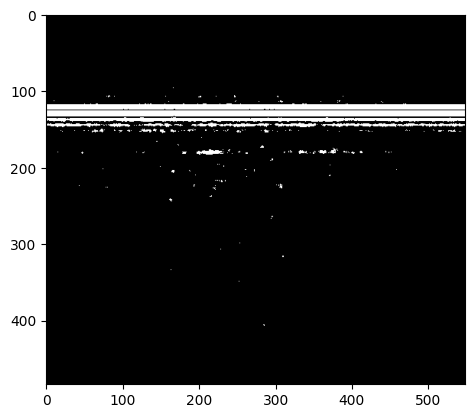

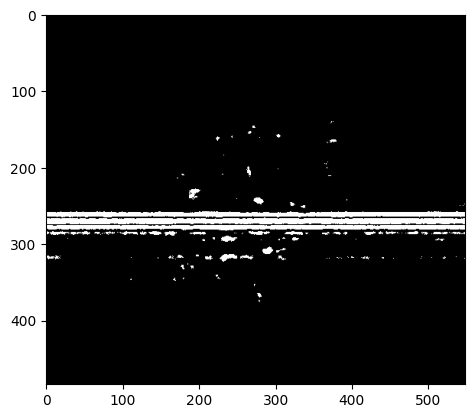

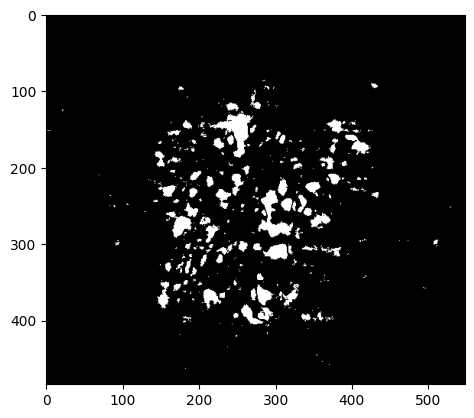

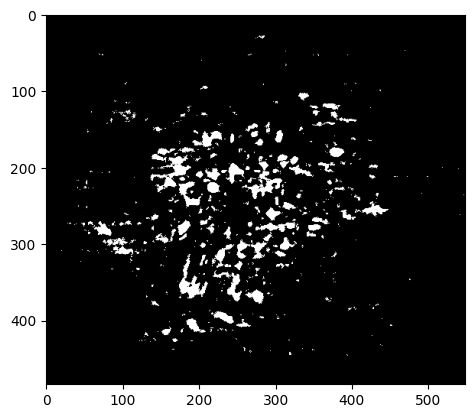

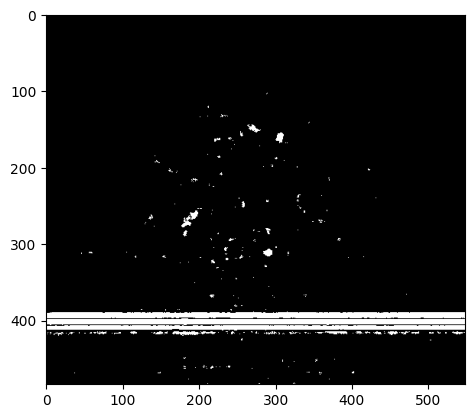

In [19]:
#| layout-ncol: 3
#| layout-nrow: 3
#| fig-cap: 
#|   - "Component 1"
#|   - "Component 2"
#|   - "Component 3"
#|   - "Component 4"
#|   - "Component 5"
#|   - "Component 6"
#|   - "Component 7"
#|   - "Component 8"
#|   - "Component 9"

for i in range(len(component_maps)):
    ret, component_maps[i] = cv2.threshold(component_maps[i], np.quantile(component_maps[i], 0.95), 255, cv2.THRESH_BINARY)  # type: ignore


for i in range(9):
    fig, ax = plt.subplots()
    ax.imshow(component_maps[i], cmap='gray')

Ara apliquem la transformada de Hough per a línies.
Els paràmatres especifiquen el mínim per poder detectar una línia, en longitud, i el maxim de distancia entre pixels
blancs per poder considerar-ho la mateixa linia o distinta.
També explorem només línies horitzontals i verticals, amb el bot de 90 graus en theta.


In [20]:
is_component_selected: list[bool] = []
for map in component_maps:
    lines = cv2.HoughLinesP(
        map,
        rho=1,  # resolution of the parameter rho (1 pixel)
        theta=math.pi / 2,  # resolution of the theta parameter (90 degree)
        threshold=200,
        lines=None,
        minLineLength=150,
        maxLineGap=5,
    )
    is_component_selected.append(lines is None)

for i in range(9):
    print(f"Component {i + 1} {'does not contain noise.' if is_component_selected[i] else 'contains noise.'}")

Component 1 contains noise.
Component 2 contains noise.
Component 3 contains noise.
Component 4 contains noise.
Component 5 contains noise.
Component 6 contains noise.
Component 7 does not contain noise.
Component 8 does not contain noise.
Component 9 contains noise.


Veiem com detecta correctament aquelles components que conten soroll.

:::{.callout-caution}
És important no tindre massa components, ja que en 200 components o més les línies de soroll es reparteixen al llarg de d'aquestes,
sent més fines i molt més difícils de detectar.
Allò ideal seria treballar amb un 95% de components amb unes 100 components.
:::

### Selecció manual

També podem trobar en ica.py un selector manual, que et mostra la imatge de cada component
i has d'anar decidint si la vols per a la reconstrucció o no.

Per a 100 components es tarda a penes 3 minuts, i és una alternativa en cas que la selecció automàtica falle
per alguna raó.

## Reconstruim el video

Finalment, només ens queda reconstruir el video amb les components seleccionades.

In [21]:
inverted_selection = np.invert(is_component_selected)
inverted_indices = [
    i for i, include in enumerate(inverted_selection) if include
]
remaining_components = ica_components.copy()
remaining_components[:, inverted_indices] = 0
# Reconstruct, reshape and normalize frames
data = ica.inverse_transform(remaining_components)
data = pca.inverse_transform(data)
video = data.reshape(-1, *frame_shape)

I el guardem (guardar en mp4 no te dependencies, en canvi lossless necessita tindre el programa ffmpeg).

In [22]:
def save_frames_as_mp4(frames, output_path):
    frames = cv2.normalize(frames, None, 0, 255, cv2.NORM_MINMAX).astype(  # type: ignore
            np.uint8
    )

    fourcc = cv2.VideoWriter.fourcc(*"mp4v")
    out = cv2.VideoWriter(
        output_path,
        fourcc,
        fps,
        (frame_shape[1], frame_shape[0]),
        isColor=False,
    )

    for frame in frames:
        out.write(frame)

    out.release()
    print(f"Video saved as {output_path}")

def save_frames_lossless(frames, output_path):
    frames = cv2.normalize(frames, None, 0, 255, cv2.NORM_MINMAX).astype(  # type: ignore
            np.uint8
    )

    writer = skvideo.io.FFmpegWriter(output_path, outputdict={
        '-r': f'{fps}',
        '-vcodec': 'libx264',  #use the h.264 codec
        '-crf': '0',           #set the constant rate factor to 0, which is lossless
        '-preset':'veryslow',   #the slower the better compression, in princple, try 
                             #other options see https://trac.ffmpeg.org/wiki/Encode/H.264
        },
        inputdict={
        '-r': f'{fps}'
        }) 
    for frame in frames:
        writer.writeFrame(frame)  #write the frame as RGB not BGR

    writer.close() #close the writer
    print(f"Video saved as {output_path}")

In [23]:
save_frames_lossless(video, "denoised.avi")

Video saved as denoised.mp4


Video saved as denoised.avi


[Denoised video](denoised.avi)

## Reconstruim les components no utilitzades

Per asegurar-nos que no hem llevat informació de les neurones, podem reconstruir
totes les components que no hem utilitzat i vore que video ens dona.
Si tot ha functionat bé, només deuria incloure les línies de soroll.

In [24]:
inverted_selection = is_component_selected
inverted_indices = [
    i for i, include in enumerate(inverted_selection) if include
]
remaining_components = ica_components.copy()
remaining_components[:, inverted_indices] = 0
# Reconstruct, reshape and normalize frames
data = ica.inverse_transform(remaining_components)
data = pca.inverse_transform(data)
video = data.reshape(-1, *frame_shape)

save_frames_lossless(video, "noise.avi")

Video saved as noise.mp4


Video saved as noise.avi


[Only noise video](noise.avi)

## Mètodes que no han funcionat

Primerament vam provar amb la transformada de fourier discreta bidimensional.
Així, en el espai de freqüencies llevem les components de freüencia alta i reconstruim la imatge.

El problema era que el soroll és tan notable, que per llevar-lo de veres haviem de eliminar massa freüencies, llevant
així massa informació de la imatge.

També es va intentar amb alguna IA que lleva soroll, però en aquest cas, una vegada més, es tan notable el soroll
que no es sol identificar com a tal, sino com a part de la imatge.
Això ens porta a que necessitem tractar-lo com una component important del video, i no només com a soroll de fons.

La transformada de Hilbert-Huang no era capaç de codificar suficientment bé el video en senyals bidimensionals,
i la reconstrucció era roïn.
Per últim, el PCA i ICA no va funcionar fins aplicar el filtre gaussia espacial previ, ja que
hi havia massa soroll de alta freqüencia, que dificualtava la separació de components principals
i la corva de variança creixia massa espai, requerint 500 components o més per retindre la major quantitat
de detalls del video.

## Possibles millores

En aquest programa usem el PCA i el ICA per decomposar el video en components.
Una possible millora seria utilitzar, enlloc del PCA, un mètode de descomposició
tensorial, ja que no hauriem de aplanar la matriu de 3 dimensions a 2, i amb la estructura
extra de 3 dimensions les components tindrien més informació, és a dir, obtindriem menys
i més significatives segurament, mantenint les 2 dimensions espacials dels pixels enlloc
de convertirlos a una senyal unidimensional, com el vist per exemple en 
[Tensor Principal Component Analysis in High Dimensional CP Models](https://arxiv.org/abs/2108.04428).
O qualsevol que aplique la Tucker decomposition o millor la Canonical Polyadic Decomposition.

Realment no crec que siga necessari per a llevar soroll ja que aquest ho fa suficientment bé, però per
a altres anàlisis dels components dels videos més complexes podria ajudar.